# Super resolución de imágenes usando redes convolucionales
**Autores**

* Oleg Sovero
* Jose Huertas
* Gustavo Rojas
* Alfredo Tarazona

In [39]:
# Fuentes de información:
# https://keras.io/examples/vision/super_resolution_sub_pixel/
# https://blog.paperspace.com/image-super-resolution/

In [40]:
# Importamos las librerias
import os
import math
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display


In [41]:
# Montar en el directorio de drive, asi no gastamos mucha ram
from google.colab import drive
drive.mount('/content/drive')
working_dir = "/content/drive/MyDrive/Dataset/SIR_backup"
%cd $working_dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1HWgELbfAzgbCmGvQOJLuIEqQ7rDlmM_v/Dataset/SIR_backup


In [42]:
%ls $working_dir

Test_Set/  Training_Set/  Validation_Set/


In [43]:
train_path = working_dir + '/Training_Set'
valid_path = working_dir + '/Validation_Set'

In [44]:
# Mis cambios
crop_size = 300
upscale_factor = 2
input_size = crop_size // upscale_factor
batch_size = 5

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    valid_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)


Found 64 files belonging to 1 classes.
Using 52 files for training.
Found 31 files belonging to 1 classes.
Using 6 files for validation.


Escalamos las imagenes

In [45]:
# Escalamos las imágenes para que el valor de cada píxel este en el rango de 0 y 1
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)


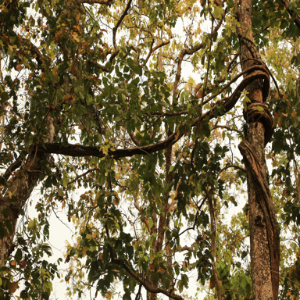

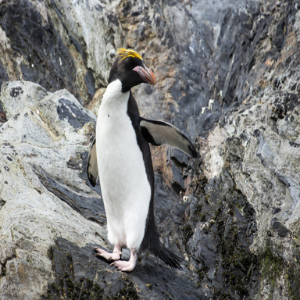

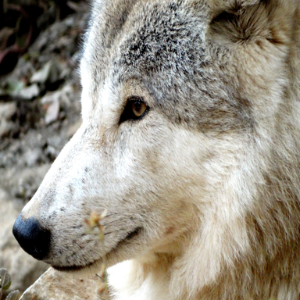

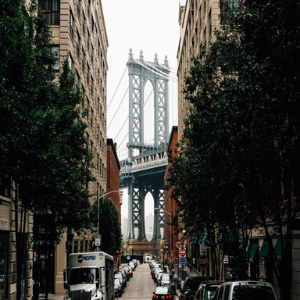

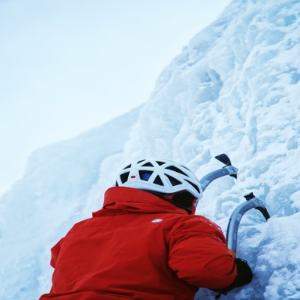

In [46]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))


Creamos el conjunto de testeo

In [47]:
test_path = working_dir + '/Test_Set'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)


In [48]:
# Preprocesamos las imagenes
# Usar TF Ops para procesar.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)


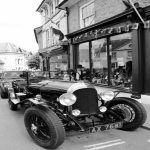

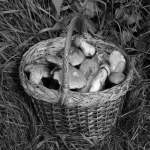

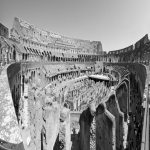

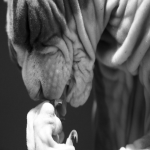

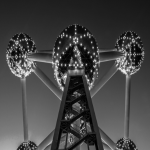

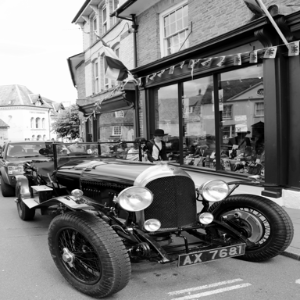

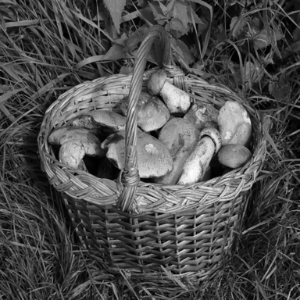

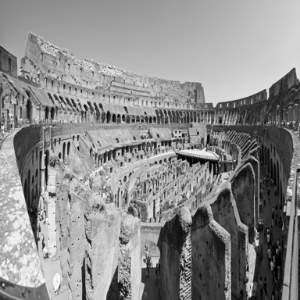

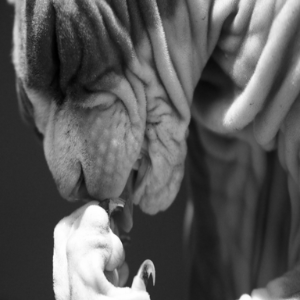

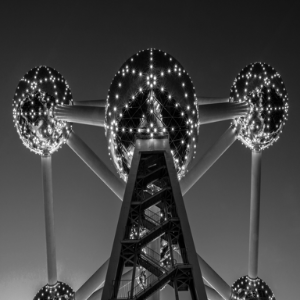

In [49]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


Construimos el modelo

In [50]:
def get_model(upscale_factor=3, channels=1):
    #initializer = tf.random_normal_initializer(0. , 0.02)
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        #"kernel_initializer": initializer,
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 3, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(16, 3, **conv_args)(x)
    x = layers.Conv2DTranspose(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

Definimos funciones de utilidad

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Especificar los limites.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Aplicar los x-limits.
    axins.set_xlim(x1, x2)
    # Aplicar los y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Dibujar la línea.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restaurar la imagen.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [52]:
# Usamos ESPCN como un callback para imprimir las métricas en cada época.
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Almacenar valor PSNR en cada epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))



In [53]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = working_dir + "/Temp"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 64)    640       
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 16)    4624      
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, None, None, 4)    580       
 ranspose)                                                       
                                                           

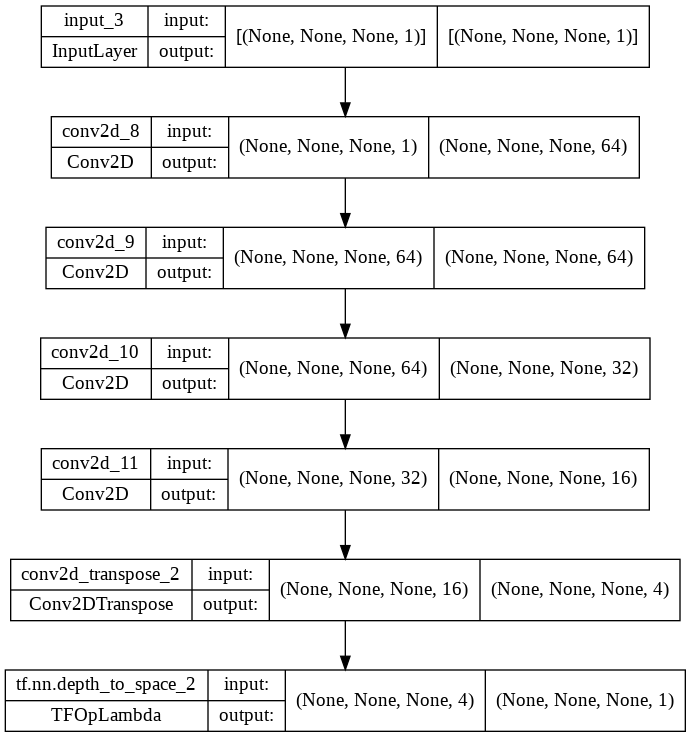

In [54]:
# Graficamos el modelo
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Entrenamos el modelo

Epoch 1/150
Mean PSNR for epoch: 9.28


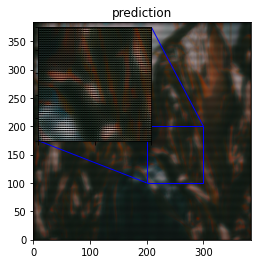

11/11 - 4s - loss: 0.1724 - val_loss: 0.1189 - 4s/epoch - 385ms/step
Epoch 2/150
Mean PSNR for epoch: 10.74
11/11 - 1s - loss: 0.0785 - val_loss: 0.0850 - 786ms/epoch - 71ms/step
Epoch 3/150
Mean PSNR for epoch: 11.00
11/11 - 1s - loss: 0.0672 - val_loss: 0.0780 - 743ms/epoch - 68ms/step
Epoch 4/150
Mean PSNR for epoch: 11.21
11/11 - 1s - loss: 0.0640 - val_loss: 0.0759 - 752ms/epoch - 68ms/step
Epoch 5/150
Mean PSNR for epoch: 11.35
11/11 - 1s - loss: 0.0620 - val_loss: 0.0720 - 727ms/epoch - 66ms/step
Epoch 6/150
Mean PSNR for epoch: 17.54
11/11 - 1s - loss: 0.0264 - val_loss: 0.0176 - 736ms/epoch - 67ms/step
Epoch 7/150
Mean PSNR for epoch: 20.13
11/11 - 1s - loss: 0.0096 - val_loss: 0.0097 - 769ms/epoch - 70ms/step
Epoch 8/150
Mean PSNR for epoch: 21.17
11/11 - 1s - loss: 0.0061 - val_loss: 0.0077 - 735ms/epoch - 67ms/step
Epoch 9/150
Mean PSNR for epoch: 21.83
11/11 - 1s - loss: 0.0047 - val_loss: 0.0067 - 758ms/epoch - 69ms/step
Epoch 10/150
Mean PSNR for epoch: 22.89
11/11 - 1s 

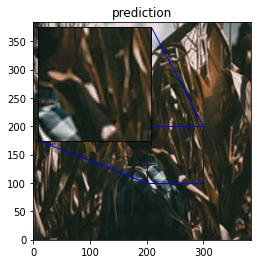

11/11 - 1s - loss: 0.0018 - val_loss: 0.0026 - 1s/epoch - 131ms/step
Epoch 22/150
Mean PSNR for epoch: 25.99
11/11 - 1s - loss: 0.0017 - val_loss: 0.0025 - 738ms/epoch - 67ms/step
Epoch 23/150
Mean PSNR for epoch: 26.05
11/11 - 1s - loss: 0.0017 - val_loss: 0.0025 - 725ms/epoch - 66ms/step
Epoch 24/150
Mean PSNR for epoch: 26.06
11/11 - 1s - loss: 0.0016 - val_loss: 0.0025 - 761ms/epoch - 69ms/step
Epoch 25/150
Mean PSNR for epoch: 26.24
11/11 - 1s - loss: 0.0016 - val_loss: 0.0024 - 731ms/epoch - 66ms/step
Epoch 26/150
Mean PSNR for epoch: 26.14
11/11 - 1s - loss: 0.0016 - val_loss: 0.0024 - 751ms/epoch - 68ms/step
Epoch 27/150
Mean PSNR for epoch: 26.18
11/11 - 1s - loss: 0.0016 - val_loss: 0.0024 - 758ms/epoch - 69ms/step
Epoch 28/150
Mean PSNR for epoch: 26.15
11/11 - 1s - loss: 0.0016 - val_loss: 0.0024 - 813ms/epoch - 74ms/step
Epoch 29/150
Mean PSNR for epoch: 24.27
11/11 - 1s - loss: 0.0020 - val_loss: 0.0038 - 677ms/epoch - 62ms/step
Epoch 30/150
Mean PSNR for epoch: 26.06
11/

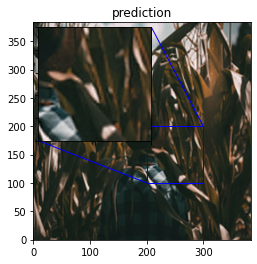

11/11 - 1s - loss: 0.0015 - val_loss: 0.0022 - 1s/epoch - 132ms/step
Epoch 42/150
Mean PSNR for epoch: 26.55
11/11 - 1s - loss: 0.0015 - val_loss: 0.0022 - 759ms/epoch - 69ms/step
Epoch 43/150
Mean PSNR for epoch: 26.24
11/11 - 1s - loss: 0.0015 - val_loss: 0.0024 - 667ms/epoch - 61ms/step
Epoch 44/150
Mean PSNR for epoch: 25.28
11/11 - 1s - loss: 0.0017 - val_loss: 0.0029 - 677ms/epoch - 62ms/step
Epoch 45/150
Mean PSNR for epoch: 24.85
11/11 - 1s - loss: 0.0020 - val_loss: 0.0032 - 671ms/epoch - 61ms/step
Epoch 46/150
Mean PSNR for epoch: 26.34
11/11 - 1s - loss: 0.0018 - val_loss: 0.0023 - 745ms/epoch - 68ms/step
Epoch 47/150
Mean PSNR for epoch: 26.51
11/11 - 1s - loss: 0.0015 - val_loss: 0.0022 - 664ms/epoch - 60ms/step
Epoch 48/150
Mean PSNR for epoch: 26.49
11/11 - 1s - loss: 0.0015 - val_loss: 0.0022 - 717ms/epoch - 65ms/step
Epoch 49/150
Mean PSNR for epoch: 26.44
11/11 - 1s - loss: 0.0015 - val_loss: 0.0022 - 813ms/epoch - 74ms/step
Epoch 50/150
Mean PSNR for epoch: 26.63
11/

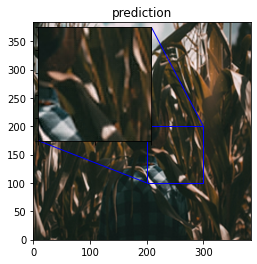

11/11 - 1s - loss: 0.0014 - val_loss: 0.0022 - 1s/epoch - 131ms/step
Epoch 62/150
Mean PSNR for epoch: 26.73
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 686ms/epoch - 62ms/step
Epoch 63/150
Mean PSNR for epoch: 26.69
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 730ms/epoch - 66ms/step
Epoch 64/150
Mean PSNR for epoch: 26.79
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 789ms/epoch - 72ms/step
Epoch 65/150
Mean PSNR for epoch: 26.69
11/11 - 1s - loss: 0.0014 - val_loss: 0.0022 - 747ms/epoch - 68ms/step
Epoch 66/150
Mean PSNR for epoch: 26.74
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 668ms/epoch - 61ms/step
Epoch 67/150
Mean PSNR for epoch: 26.72
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 679ms/epoch - 62ms/step
Epoch 68/150
Mean PSNR for epoch: 26.78
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 785ms/epoch - 71ms/step
Epoch 69/150
Mean PSNR for epoch: 26.78
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 739ms/epoch - 67ms/step
Epoch 70/150
Mean PSNR for epoch: 26.78
11/

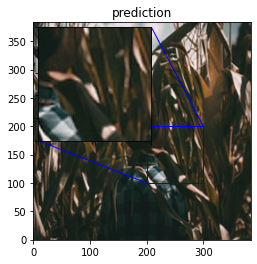

11/11 - 1s - loss: 0.0014 - val_loss: 0.0022 - 1s/epoch - 122ms/step
Epoch 82/150
Mean PSNR for epoch: 26.73
11/11 - 1s - loss: 0.0014 - val_loss: 0.0021 - 734ms/epoch - 67ms/step


In [55]:
epochs = 150

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# Mejores pesos se guardan en el modelo.
model.load_weights(checkpoint_filepath)


Resultados del modelo entrenado

PSNR of low resolution image and high resolution image is 23.9643
PSNR of predict and high resolution is 24.5046


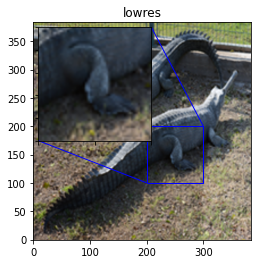

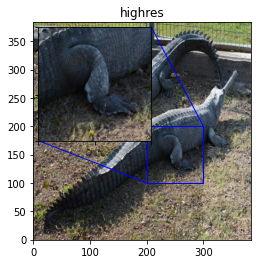

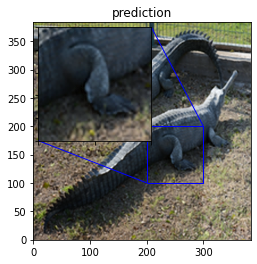

PSNR of low resolution image and high resolution image is 29.7270
PSNR of predict and high resolution is 31.6952


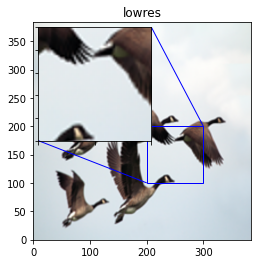

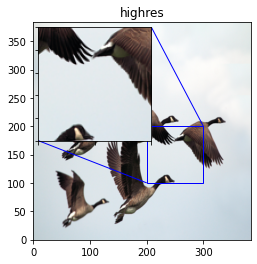

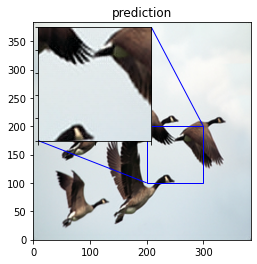

PSNR of low resolution image and high resolution image is 22.1813
PSNR of predict and high resolution is 23.4115


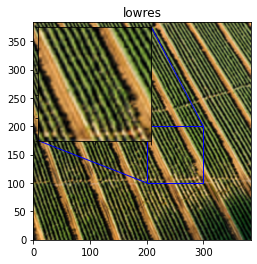

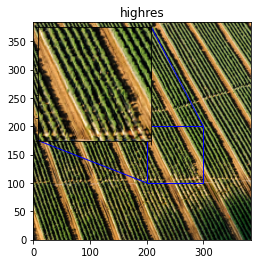

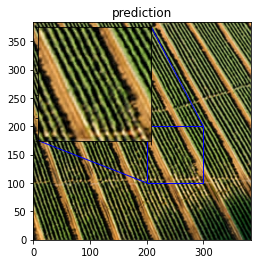

PSNR of low resolution image and high resolution image is 30.2236
PSNR of predict and high resolution is 30.7419


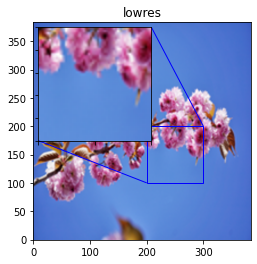

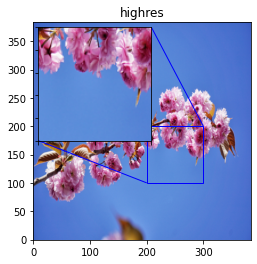

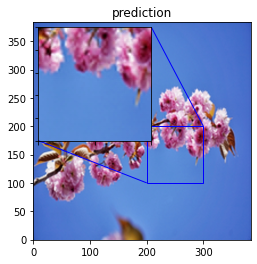

PSNR of low resolution image and high resolution image is 25.7488
PSNR of predict and high resolution is 27.3884


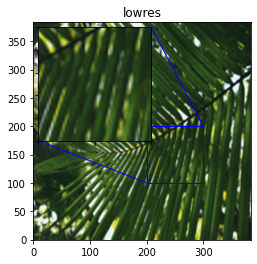

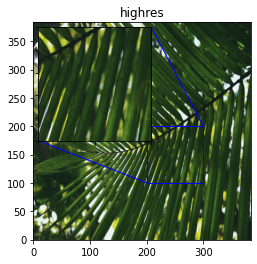

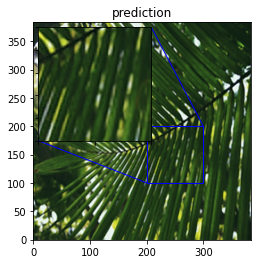

PSNR of low resolution image and high resolution image is 25.2376
PSNR of predict and high resolution is 26.0476


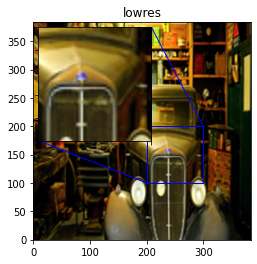

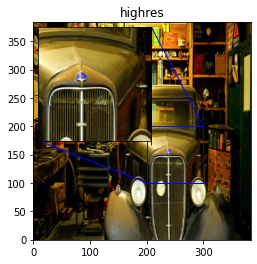

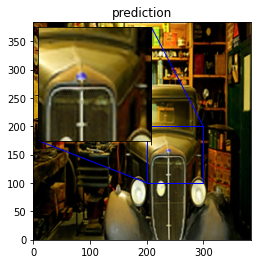

Contador:  6
Avg. PSNR of lowres images is 26.1804
Avg. PSNR of reconstructions is 27.2982


In [56]:
# Resultados del modelo entrenado
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
contador = 0
for index, test_img_path in enumerate(test_img_paths[2:12]):
    contador = contador + 1
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Contador: ", contador)
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / contador))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / contador))

